# BioscrapeCOBRA: a multi-paradigm composite of FBA, CRN, and physics engine

Vivarium is a powerful tool for combining previously-isolated frameworks in computational biology.
This notebook demonstrates the integration of flux balance analysis (FBA), chemical reaction networks (CRNs), and a physics engine, to simulate many individual cells in a spatial environment.


Processes include:
* Bioscrape
* COBRA
* Multibody (pymunk)

Processes accept standard formats:
* SBML
* BiGG model

In [1]:
#Uncomment in Colab Below

"""
%%capture
!pip install git+https://github.com/vivarium-collective/vivarium-notebooks
!pip install vivarium-core==0.1.22
!pip install vivarium-cobra==0.0.6
!pip install vivarium-pymunk==0.0.2
!pip install vivarium-bioscrape
"""
    
# assert correct library versions are loaded
#from importlib.metadata import version
#assert version('vivarium-core') == '0.1.11'
#assert version('vivarium-cobra') == '0.0.7'
#assert version('vivarium-bioscrape') == '0.0.0.5'
#assert version('vivarium-multibody') == '0.0.4'

In [3]:
%%capture
pip install git+git://github.com/vivarium-collective/vivarium-notebooks.git

  Cloning git://github.com/vivarium-collective/vivarium-notebooks.git to /private/var/folders/t4/q28s90qs5r755xvnzjg6vkc40000gn/T/pip-req-build-xw5mb_x2
  Running command git clone -q git://github.com/vivarium-collective/vivarium-notebooks.git /private/var/folders/t4/q28s90qs5r755xvnzjg6vkc40000gn/T/pip-req-build-xw5mb_x2
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pylab as plt

# process/composition interface
from vivarium.core.process import (
    Process, 
    Deriver, 
    Composer,
)
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# helper functions for composition
from vivarium.core.composition import (
    process_in_experiment,
    simulate_composer,
    composer_in_experiment,
    compose_experiment,
    COMPOSER_KEY,
)

# vivarium plotting functions
from vivarium.plots.simulation_output import (
    plot_simulation_output, 
    plot_variables, 
    save_fig_to_dir,
)
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology

# vivarium-core processes and composites
from vivarium.processes.tree_mass import TreeMass
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision

plot_var_config = {
    'row_height': 2,
    'row_padding': 0.2,
    'column_width': 10,
    'out_dir': 'out'}

# The three paradigms on their own

## **Paradigm 1**: Flux Balance Analysis with COBRA

[Constraint-based reconstruction and analysis (COBRA)](https://cobrapy.readthedocs.io/en/latest/) is a popular FBA solver.

The [vivarium-cobra library](https://github.com/vivarium-collective/vivarium-cobra) provides a Vivarium wrapper process for COBRA:
 ```
 pip install vivarium-cobra
 ```
 
* The COBRA process can load [BiGG metabolic models](http://bigg.ucsd.edu) -- over 100 models are available, including dozens of *E. coli* strains. 
* Here, *iAF1260b* is loaded, which has 2382 reactions, 1261 genes, and 166 metabolites.
* The objective function, with 67 molecules, is stored in internal pools. There are 299 external molecules -- of these, 19 show dynamics in minimal glucose conditions.

In [5]:
# vivarium-cobra processes
from vivarium_cobra.processes.volume import Volume
from vivarium_cobra.composites.cobra_composite import CobraComposite
from vivarium_cobra.processes.dynamic_fba import (
    DynamicFBA, 
    get_iAF1260b_config, 
    print_growth
)

# set cobra constrained reactions config
cobra_config = get_iAF1260b_config()

# plotting
tags_dict = {
    'glc__D_e': 'tab:cyan',
    'co2_e': 'tab:orange',
    'h2o_c': 'tab:cyan',
    'atp_c': 'tab:orange',
    'asp__L_c': 'tab:green'
}

def move_to_end(data, d):
    for key in d.keys():
        if key in data:
            data[key] = data.pop(key)
    return data

def plot_metabolism(data, tags=tags_dict):

    # initialize subplots
    n_rows = 3
    n_cols = 1
    fig = plt.figure(figsize=(n_cols * 8, n_rows * 2))
    grid = plt.GridSpec(n_rows, n_cols)

    time_vec = data['time']

    # external
    ax = fig.add_subplot(grid[0, 0])
    external = move_to_end(data['external'], tags)
    for mol_id, series in external.items():
        if sum(series) != 0.0:
            ax.plot(
                time_vec, 
                series, 
                label=mol_id if mol_id in tags else None, 
                color=tags.get(mol_id,'tab:gray'),
            )
    ax.set_title(f'external ({len(external.keys())} species)')
    ax.set_ylabel('concentrations (mmol)')
    ax.set_yscale('log')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    # internal
    ax = fig.add_subplot(grid[1, 0])
    internal = move_to_end(data['internal_counts'], tags)
    for mol_id, series in internal.items():
        if sum(series) != 0.0:
            ax.plot(
                time_vec, 
                series, 
                label=mol_id if mol_id in tags else None, 
                color=tags.get(mol_id,'tab:gray'),
            )
    ax.set_title(f'internal ({len(internal.keys())} species)')
    ax.set_ylabel('counts')
    ax.set_yscale('log')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    # mass
    ax = fig.add_subplot(grid[2, 0])
    ax.plot(
        time_vec, 
        data['global'][('mass', 'femtogram')], 
        color='tab:blue',
    )
    ax.set_title('global')
    ax.set_ylabel('total mass (fg)')
    ax.set_xlabel('time (sec)')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    fig.tight_layout()   
    return fig

### run COBRA process

In [6]:
# get the configuration for the iAF1260b BiGG model
config = get_iAF1260b_config()
config.update({'time_step': 10})
iAF1260b_config = {'cobra': config}   

# load iAF1260b into CobraComposite
dynamic_fba = CobraComposite(iAF1260b_config)

# get the initial state
initial_state = dynamic_fba.initial_state({}) 

# run simulation
cobra_sim_settings = {
    'initial_state': initial_state,
    'total_time': 2000}
cobra_timeseries = simulate_composer(dynamic_fba, cobra_sim_settings)


Experiment ID: 0502eaca-7707-11eb-ba22-acde48001122
Created: 02/24/2021 at 17:15:59
Completed in 24.57 seconds


### plot COBRA output

In [7]:
external = [key for key, series in cobra_timeseries['external'].items() if sum(series) != 0]
print(f"EXTERNAL: {external}")

internal = [key for key, series in cobra_timeseries['internal_counts'].items() if sum(series) != 0]
print(f"INTERNAL: {internal}")

EXTERNAL: ['cl_e', 'co2_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e', 'h2o_e', 'h_e', 'glc__D_e', 'k_e', 'pi_e', 'mg2_e', 'mn2_e', 'mobd_e', 'nh4_e', 'so4_e', 'o2_e', 'zn2_e', 'ca2_e']
INTERNAL: ['10fthf_c', '2ohph_c', 'ala__L_c', 'amet_c', 'arg__L_c', 'asn__L_c', 'asp__L_c', 'atp_c', 'ca2_c', 'cl_c', 'coa_c', 'cobalt2_c', 'ctp_c', 'cu2_c', 'cys__L_c', 'datp_c', 'dctp_c', 'dgtp_c', 'dttp_c', 'fad_c', 'fe2_c', 'fe3_c', 'gln__L_c', 'glu__L_c', 'gly_c', 'gtp_c', 'h2o_c', 'his__L_c', 'ile__L_c', 'k_c', 'kdo2lipid4_e', 'leu__L_c', 'lys__L_c', 'met__L_c', 'mg2_c', 'mlthf_c', 'mn2_c', 'mobd_c', 'murein5px4p_p', 'nad_c', 'nadp_c', 'nh4_c', 'pe160_c', 'pe160_p', 'pe161_c', 'pe161_p', 'phe__L_c', 'pheme_c', 'pro__L_c', 'pydx5p_c', 'ribflv_c', 'ser__L_c', 'sheme_c', 'so4_c', 'thf_c', 'thmpp_c', 'thr__L_c', 'trp__L_c', 'tyr__L_c', 'udcpdp_c', 'utp_c', 'val__L_c', 'zn2_c']


volume growth: 1.708809161242802
mass growth: 1.708809161242802


Writing out/cobra_output.pdf


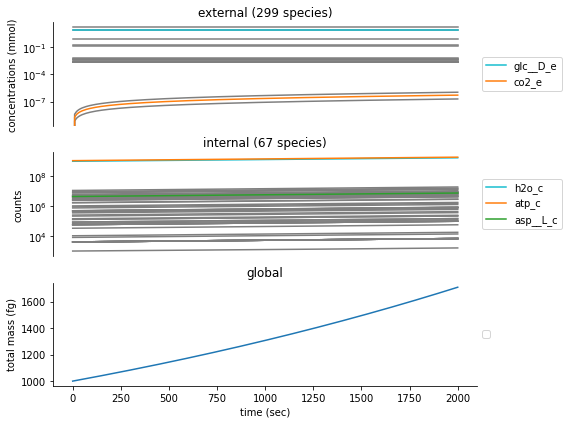

In [8]:
print_growth(cobra_timeseries['global'])
fig = plot_metabolism(cobra_timeseries)
save_fig_to_dir(fig, 'cobra_output.pdf')

## **Paradigm 2**: Chemical Reaction Network with Bioscrape

Bioscrape is an easily extensible and modular object-oriented framework for building and simulating CRNs. Bioscrape Process loads Systems Biology Markup Language (SBML) files.

The [vivarium-bioscrape library](https://github.com/vivarium-collective/vivarium-bioscrape) provides a Vivarium wrapper process for Bioscrape:
 ```
 pip install vivarium-bioscrape
 ```

In [9]:
# vivarium-bioscrape processes
from vivarium_bioscrape.processes.bioscrape import Bioscrape

SBML_FILE_DETERMINISTIC = 'models/LacOperon_deterministic.xml'
SBML_FILE_STOCHASTIC = 'models/LacOperon_stochastic.xml'

#choose the SBML file and set other bioscrape parameters
deterministic_bioscrape_config = {
            'sbml_file': SBML_FILE_DETERMINISTIC,
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,
}

stochastic_bioscrape_config = {
            'sbml_file': SBML_FILE_STOCHASTIC,
            'stochastic': True,
            'safe_mode': False,
            'initial_volume': 1,
            'internal_dt': 0.1,
}

# global configs
plotted_bioscrape_variables = {
    'variables':[
        ('species', 'Glucose_external'), 
        ('species', 'Lactose_external'), 
        ('species', 'rna_M'), 
        ('species', 'protein_betaGal'),
        ('species', 'protein_Lactose_Permease')
        ]}

### run Bioscrape Process with deterministic simulator

In [10]:
# initialize Bioscrape process
total_time = 2500
time_step = 10

#This will configure a deterministic model as a system of ODEs
deterministic_bioscrape_config = {
            'sbml_file': SBML_FILE_DETERMINISTIC,
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,
            'time_step':time_step}
deterministic_process = Bioscrape(deterministic_bioscrape_config)

# get initial state
initial_state = deterministic_process.initial_state()

# make an experiment
deterministic_experiment = process_in_experiment(deterministic_process, initial_state=initial_state)

# run the experiment
deterministic_experiment.update(total_time)


Experiment ID: 14ee5a5a-7707-11eb-ba22-acde48001122
Created: 02/24/2021 at 17:16:26
Completed in 0.207523 seconds


### plot deterministic Bioscrape output

Writing out/bioscrape_deterministic.pdf


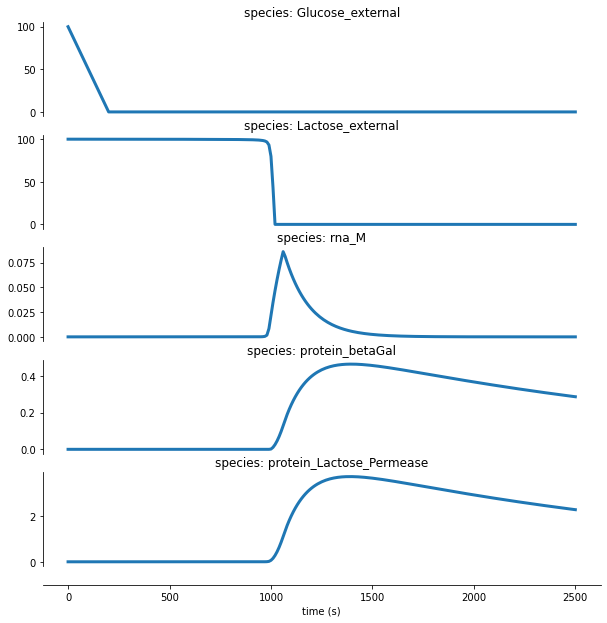

In [11]:
# retrieve the data
deterministic_timeseries = deterministic_experiment.emitter.get_timeseries()

# plot output
deterministic_plot_config = {
    'filename': 'bioscrape_deterministic.pdf',
    **plotted_bioscrape_variables,
    **plot_var_config}
fig = plot_variables(deterministic_timeseries, **deterministic_plot_config)


### run Bioscrape Process with stochastic simulator

In [12]:
#Run the simulation
total_time = 5000

bioscrape_process_stochastic = Bioscrape(stochastic_bioscrape_config)

# initial state
initial_state = bioscrape_process_stochastic.initial_state()
# print(initial_state)

# make an experiment
stochastic_experiment = process_in_experiment(bioscrape_process_stochastic, initial_state=initial_state)

# run the experiment
stochastic_experiment.update(total_time)



Experiment ID: 15771fd4-7707-11eb-ba22-acde48001122
Created: 02/24/2021 at 17:16:27
Completed in 7.02 seconds


### plot stochastic Bioscrape output

Writing out/bioscrape_stochastic.pdf


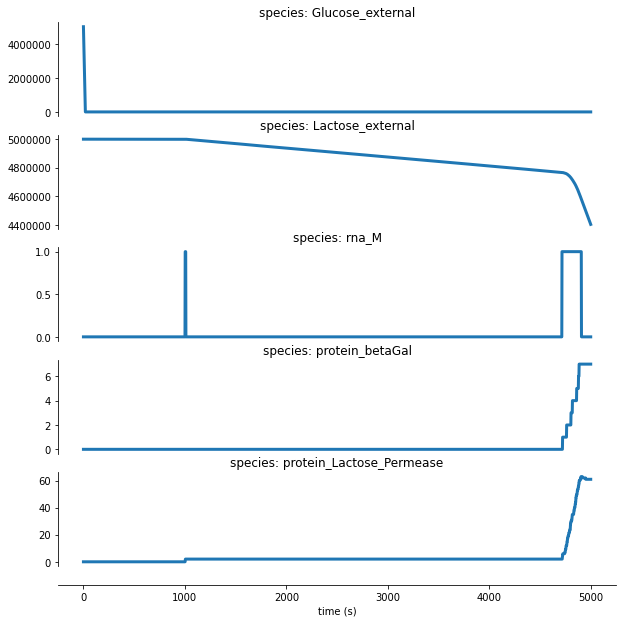

In [13]:
# retrieve the data
stochastic_timeseries = stochastic_experiment.emitter.get_timeseries()

# plot output
stochastic_plot_config = {
    'filename': 'bioscrape_stochastic.pdf',
    **plotted_bioscrape_variables,
    **plot_var_config}
fig = plot_variables(stochastic_timeseries, **stochastic_plot_config)

## **Paradigm 3**: Multibody physics with pymunk
[pymunk](multibody) is an open-source video game physics engine.
[vivarium-multibody](https://github.com/vivarium-collective/vivarium-multibody) provides a Vivarium wrapper process for pymunk, configured specifically for multi-cellular physics:
 ```
 pip install vivarium-multibody
 ```

In [14]:
from vivarium_multibody.processes.multibody_physics import test_growth_division
from vivarium_multibody.processes.multibody_physics import agent_body_config, volume_from_length
from vivarium_multibody.plots.snapshots import (
    plot_snapshots,
    format_snapshot_data,
    make_snapshots_figure,
    get_field_range,
    get_agent_colors,
)
from vivarium_multibody.plots.snapshots import plot_tags
import numpy as np

from ipywidgets import interactive
import ipywidgets as widgets


def make_interactive(multibody_data):

    multibody_agents, multibody_fields = format_snapshot_data(multibody_data)

    # make the snapshot plot function
    time_vec = list(multibody_agents.keys()) 

    # get fields and agent colors
    multibody_field_range = get_field_range(multibody_fields, time_vec)
    multibody_agent_colors = get_agent_colors(multibody_agents)

    time_index_range = len(time_vec) -1

    def plot_single_snapshot(t_index):   
        time_indices = np.array([t_index])
        snapshot_time = [time_vec[t_index]]
        fig = make_snapshots_figure(
            time_indices=time_indices,
            snapshot_times=snapshot_time,
            agents=multibody_agents,
            agent_colors=multibody_agent_colors,
            fields=multibody_fields,
            field_range=multibody_field_range,
            n_snapshots=1,
            bounds=spatial_bounds,
            default_font_size=12,
            plot_width=7)
        
    interactive_plot = interactive(
        plot_single_snapshot, 
        t_index=widgets.IntSlider(min=0, max=time_index_range, step=2, value=0))
    
    return interactive_plot


In [15]:
total_time = 140
n_agents = 3
spatial_bounds = [70, 70]

# configure
agent_ids = [str(agent_id) for agent_id in range(n_agents)]
body_config = {'bounds': spatial_bounds, 'agent_ids': agent_ids}
multibody_config = {'bounds': spatial_bounds}
multibody_config.update(agent_body_config(body_config))

# experiment settings
experiment_settings = {'progress_bar': False, 'display_info': False}

# run multibody with grow/divide agents
multibody_data = test_growth_division(
        config=multibody_config,
        growth_rate=0.05,
        growth_rate_noise=0.05,
        division_volume=volume_from_length(4,1),
        total_time=total_time,
        experiment_settings=experiment_settings)


### interactive plot of multibody physics

In [16]:
interactive_plot = make_interactive(multibody_data)


In [17]:
interactive_plot

interactive(children=(IntSlider(value=0, description='t_index', max=140, step=2), Output()), _dom_classes=('wi…

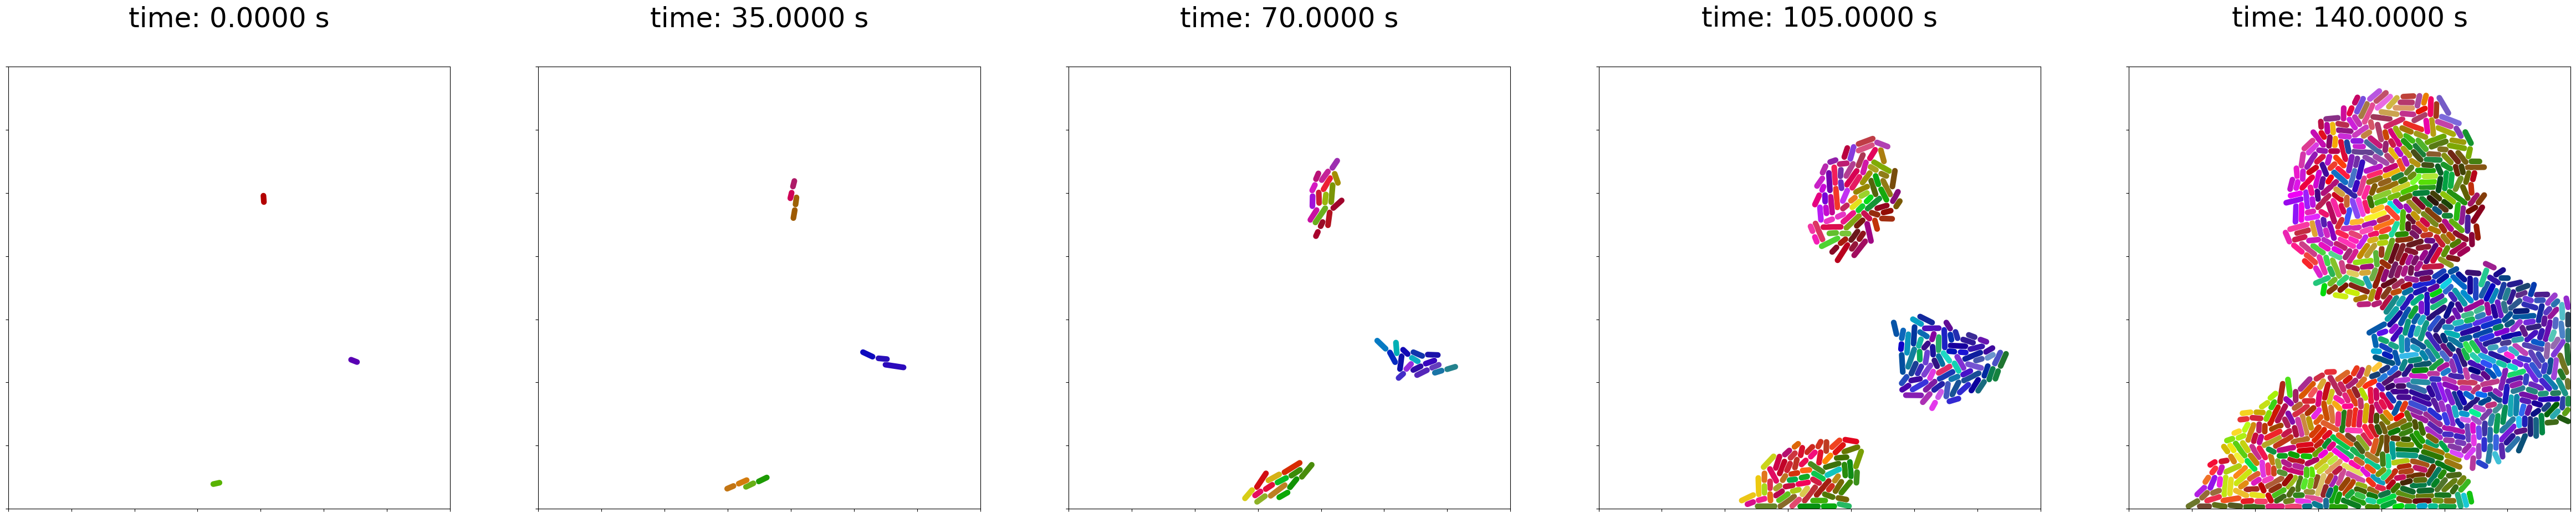

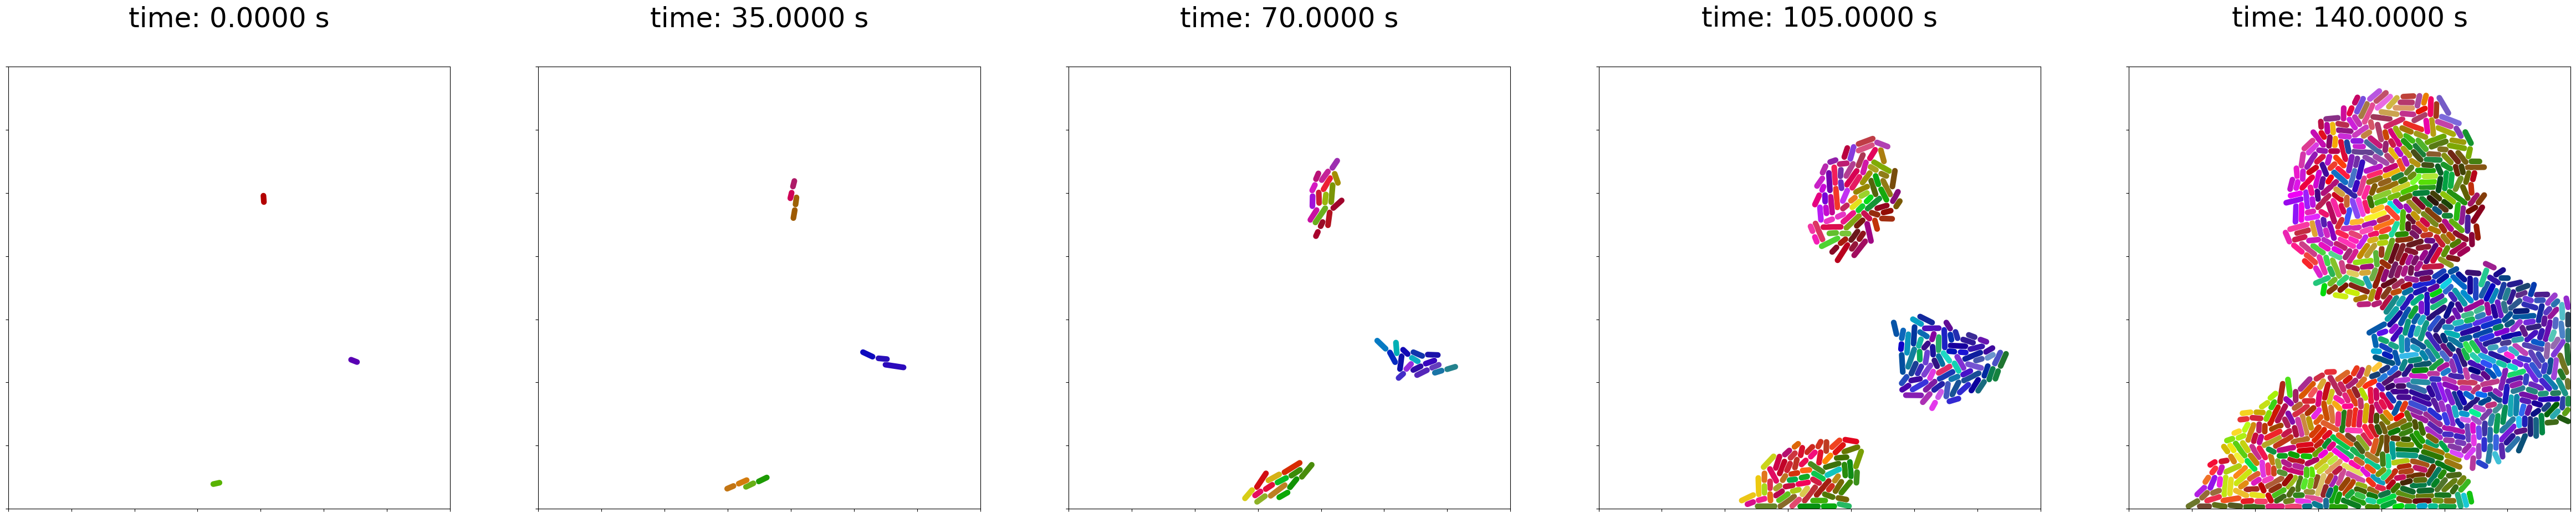

In [18]:
agents, fields = format_snapshot_data(multibody_data)
plot_snapshots(
    bounds=spatial_bounds,
    agents=agents,
    fields=fields,
    n_snapshots=5,
    out_dir='out',
    filename='multibody_snapshots.pdf',
    )

# Integration: BioscrapeCOBRA

In [1]:
%%capture
pip install git+git://github.com/vivarium-collective/vivarium-notebooks.git

In [33]:
from bioscrape_cobra.composites.bioscrape_cobra_stochastic import (
    BioscrapeCOBRAstochastic, GLUCOSE_EXTERNAL, LACTOSE_EXTERNAL)
from bioscrape_cobra.composites.bioscrape_cobra_deterministic import (
    BioscrapeCOBRAdeterministic)
from vivarium.core.experiment import Experiment
from vivarium.library.units import units
from vivarium.core.composition import compose_experiment, COMPOSER_KEY

from vivarium_multibody.composites.lattice import Lattice, make_lattice_config

# plots
from vivarium.plots.simulation_output import (
    plot_simulation_output, plot_variables)
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium_multibody.plots.snapshots import (
    format_snapshot_data, plot_snapshots)
from vivarium_multibody.plots.snapshots import plot_tags


SBML_FILE_DETERMINISTIC = 'LacOperon_deterministic.xml'
SBML_FILE_STOCHASTIC = 'LacOperon_stochastic.xml'
COBRA_TIMESTEP = 10
BIOSCRAPE_TIMESTEP = 10

# configure
biocobra_config = {
    'bioscrape': {'sbml_file': SBML_FILE_DETERMINISTIC},
    'local_fields': {
        'bin_volume': external_volume}}

# divide config
agent_id = '1'
outer_path = ('agents', agent_id,)
divide_config = {
    'bioscrape': {'sbml_file': SBML_FILE_DETERMINISTIC},
    'divide_on': True,
    'agent_id': agent_id,
    'agents_path': ('..', '..', 'agents',),
    'fields_path': ('..', '..', 'fields',),
    'dimensions_path': ('..', '..', 'dimensions',),
    'local_fields': {}}

# spatial config
spatial_config = dict(divide_config)
spatial_config['fields_on'] = True

external_volume=1e-12 * units.L
    
# lattice environment spatial config
INITIAL_GLC = 1e0
INITIAL_LAC = 1e0
BOUNDS = [20, 20]
NBINS = [10, 10]
DEPTH = 20

# plotting
plot_variables_list_stochastic = [
    ('species', GLUCOSE_EXTERNAL),
    ('species', LACTOSE_EXTERNAL),
    ('species', 'rna_M'),
    ('species', 'protein_betaGal'),
    ('species', 'protein_Lactose_Permease'),
    ('flux_bounds', 'EX_glc__D_e'),
    ('flux_bounds', 'EX_lac__D_e'),
    ('boundary', ('mass', 'femtogram')),
    ('boundary', ('volume', 'femtoliter'))]

## Deterministic BioscrapeCOBRA

### Run Deterministic BioscrapeCOBRA

## Stochastic BioscrapeCOBRA

### Run Stochastic BioscrapeCOBRA

In [16]:
total_time = 2000

# make the composer
bioscrape_composer = BioscrapeCOBRAstochastic(biocobra_config)

# get initial state
initial_state = bioscrape_composer.initial_state()
initial_state['boundary']['external'] = {
    GLUCOSE_EXTERNAL: INITIAL_GLC,
    LACTOSE_EXTERNAL: INITIAL_LAC}

# make the experiment
bioscrape_composite = bioscrape_composer.generate()
bioscrape_experiment = Experiment(
    dict(
        processes=bioscrape_composite['processes'],
        topology=bioscrape_composite['topology'],
        initial_state=initial_state,))

# run the experiment
bioscrape_experiment.update(total_time)

# retrieve data
biocobra_timeseries = bioscrape_experiment.emitter.get_timeseries()


Experiment ID: 7f3a2ff8-7732-11eb-9275-acde48001122
Created: 02/24/2021 at 22:27:13


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 434.71 seconds


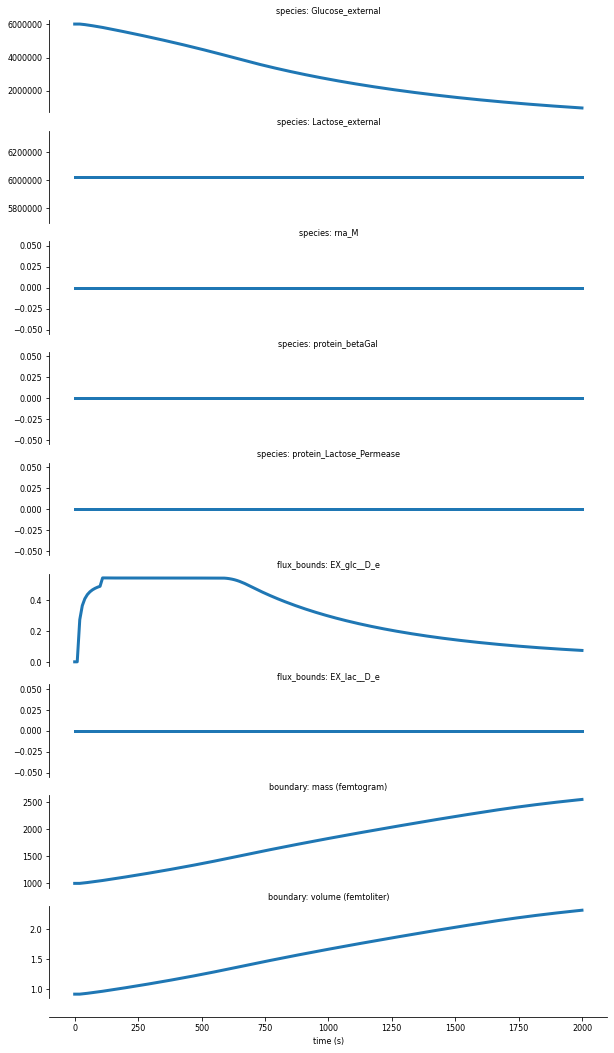

In [17]:
# plot output
variables_plot_config = {
    'filename': 'variables',
    'row_height': 2, 'row_padding': 0.2, 'column_width': 10,
    'variables': plot_variables_list_stochastic}

fig = plot_variables(biocobra_timeseries, **variables_plot_config)

## Run BioscrapeCOBRA with division

In [20]:
total_time = 5000

# configure
divide_config['local_fields']['bin_volume'] = external_volume

# make the composer
bioscrape_composer = BioscrapeCOBRAstochastic(divide_config)

# get initial state
initial_state = bioscrape_composer.initial_state()
initial_state['boundary']['external'] = {
    GLUCOSE_EXTERNAL: INITIAL_GLC,
    LACTOSE_EXTERNAL: INITIAL_LAC}
initial_state = {
    'agents': {
        agent_id: initial_state}}

# make the experiment
bioscrape_composite = bioscrape_composer.generate(path=outer_path)
bioscrape_experiment = Experiment(
    dict(
        processes=bioscrape_composite['processes'],
        topology=bioscrape_composite['topology'],
        initial_state=initial_state,))

# run the experiment
bioscrape_experiment.update(total_time)

# retrieve models
divide_timeseries = bioscrape_experiment.emitter.get_data_unitless()


Experiment ID: 18bc4cbe-7734-11eb-9275-acde48001122
Created: 02/24/2021 at 22:38:40


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 774.52 seconds


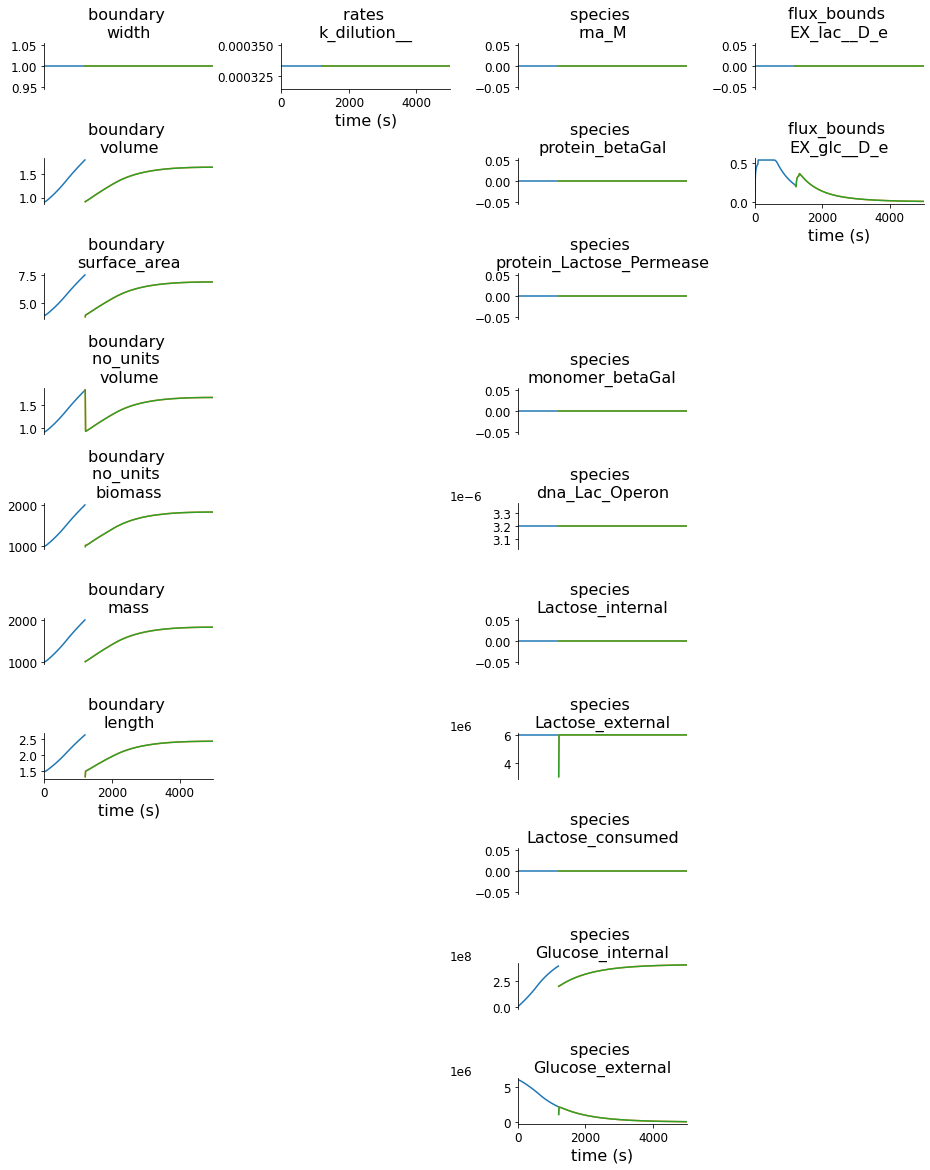

In [23]:
# multigen plots
plot_settings = {
    'skip_paths': [
        ('internal_counts',),
        ('cobra_external',),
    ],
    'remove_zeros': False}
fig = plot_agents_multigen(
    divide_timeseries, plot_settings)


## Simulate BioscrapeCOBRA in a spatial environment

In [34]:
total_time = 100

# make the composer
fields_composer = BioscrapeCOBRAstochastic(spatial_config)

# get initial state
initial_state = fields_composer.initial_state()
initial_state['boundary']['external'] = {
    GLUCOSE_EXTERNAL: INITIAL_GLC,
    LACTOSE_EXTERNAL: INITIAL_LAC}

# initial agents
initial_state = {
    'agents': {
        agent_id: initial_state}}

# initial fields
field_concentrations = {
    GLUCOSE_EXTERNAL: INITIAL_GLC,
    LACTOSE_EXTERNAL: INITIAL_LAC}

# configure lattice compartment
lattice_config_kwargs = {
    'bounds': BOUNDS,
    'n_bins': NBINS,
    'depth': DEPTH,
    'concentrations': field_concentrations,
    'diffusion': 1e-1,
    'time_step': COBRA_TIMESTEP}
lattice_config = make_lattice_config(**lattice_config_kwargs)

# declare the hierarchy
hierarchy = {
    COMPOSER_KEY: {
        'type': Lattice,
        'config': lattice_config},
    'agents': {
        agent_id: {
            COMPOSER_KEY: {
                'type': BioscrapeCOBRAstochastic,
                'config': spatial_config}}}}

# make experiment with helper function compose_experiment()
experiment_settings = {
    'initial_state': initial_state,
    'experiment_id': 'spatial_environment'}
spatial_experiment = compose_experiment(
    hierarchy=hierarchy,
    settings=experiment_settings)

# run the experiment
spatial_experiment.update(total_time)

# retrieve models
spatial_data = spatial_experiment.emitter.get_data_unitless()


Experiment ID: spatial_environment
Created: 02/24/2021 at 23:43:15


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 27.92 seconds


In [ ]:
# format models for snapshots and tags plots
agents, fields = format_snapshot_data(output)

# snapshot plot
fig = plot_snapshots(
    bounds=BOUNDS,
    agents=agents,
    fields=fields,
    include_fields=[GLUCOSE_EXTERNAL, LACTOSE_EXTERNAL],
    filename='spatial_snapshots')


In [ ]:

# tags plot
tags_data = {
    'agents': agents,
    'fields': fields,
    'config': {'bounds': BOUNDS}}
tags_config = {
    'tagged_molecules': [
        ('species', 'protein_Lactose_Permease',),
    ],
    'filename': 'spatial_tags'}
fig = plot_tags(
    data=tags_data,
    plot_config=tags_config)



## Flux Adaptor

An adaptor is a Process which can be used to convert values of one store into another type of value in another store. For example, this FluxAdaptor converts amounts of species and changes in amounts of species to instantaneous fluxes.

This FluxAdaptor is used in the composite to convert the changes of Lactose and Glucose from the CRN model into flux-bounds for the FBA model. In these cases "deltas" (changes in Species) are converted to fluxes by dividing by the timestep.

This FluxAdaptor is also used to convert changes in biomass, output from the FBA model, into a dilution rate constant used by the CRN. This flux is computered differently because the change in biomass each timestep is not stored. Additionally, dilution rate must be calculated as a percentage of the current amount, not absolute flux, and be non-negative.

## BiomassAdaptor Deriver

This adaptor is used to do unit conversion between the mass output from cobra and a Species used in the Bioscrape model to represent biomass.

## BioscrapeCOBRA configurations

This composite demonstrates advanced generate_topology() methods, which split ports across multiple stores with `'_path'`

TODO:
    * units for Biomass is in mmol/L of a species with mw of 1 fg/count = avagadro's number * fg / mol
    * import of Glucose is also in terms of 'Biomass' species
    * stochastically, it is in counts. Volume
    * logic for counts/concentrations if stochastic/deterministic
    * Bioscrape species 'Lactose_internal', 'Lactose_external' need to get wired to ('external',),
        But don't let Bioscrape update them. Only use FBA's resulting uptake.


## Stochastic BioscrapeCOBRA

Changes required for Stochastic Model
* New CRN Model without dilution and with initial conditions in counts instead of concentration
    * this means "k_dilution__" porting needs to removed from the topology
* BiomassDeriver converts to counts instead of concentration
* FluxDeriver run in "stochastic" mode where flux is averaged over the cobra update time-frame.